In [144]:
# ==== setup & config ====
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Dict, Tuple
import re
import numpy as np
import pandas as pd


# -------- configuration knobs --------
@dataclass
class PipelineConfig:
    # filtering
    start_date: Optional[pd.Timestamp] = None   # inclusive
    end_date:   Optional[pd.Timestamp] = None   # inclusive
    include_exhibitions: bool = False
    include_cancellations: bool = False

    # date-range semantics:
    # "fresh": reset cumulative at start_date (baseline=0)
    # "carry": carry all-time baseline up to (start_date - 1 day)
    range_mode: str = "fresh"   # "fresh" | "carry"

    # output
    out_dir: Path = Path("../data/tables")
    write_parquet: bool = False  # needs pyarrow/fastparquet
    write_csv: bool = True

    # misc
    verbose: bool = True


# -------- column resolution --------
@dataclass
class ColumnMap:
    Date: str
    Season_Year: Optional[str]
    Game_ID: Optional[str]
    Home_Team: str
    Away_Team: str
    Home_Score: str
    Away_Score: str
    OT: Optional[str]
    Game_Notes: Optional[str]
    Home_Team_Link: Optional[str]
    Away_Team_Link: Optional[str]
    Conference: Optional[str]

def _find_col(possible, cols) -> Optional[str]:
    norm = {c.lower().replace(" ", "_"): c for c in cols}
    for p in possible:
        k = p.lower().replace(" ", "_")
        if k in norm:
            return norm[k]
    return None

def resolve_columns(df: pd.DataFrame) -> ColumnMap:
    cols = df.columns.tolist()
    cm = ColumnMap(
        Date=_find_col(["Date"], cols) or "Date",
        Season_Year=_find_col(["Season_Year","Season","Season Year"], cols),
        Game_ID=_find_col(["Game_ID","GameID","Game Id","gid"], cols),
        Home_Team=_find_col(["Home_Team","Home Team","Home"], cols) or "Home_Team",
        Away_Team=_find_col(["Away_Team","Away Team","Away","Visitor_Team","Visitor Team"], cols) or "Away_Team",
        Home_Score=_find_col(["Home_Score","Home Score","HomeGoals","Home_Goals"], cols) or "Home_Score",
        Away_Score=_find_col(["Away_Score","Away Score","AwayGoals","Away_Goals"], cols) or "Away_Score",
        OT=_find_col(["OT","OT_SO","OT/SO","Overtime","Shootout"], cols),
        Game_Notes=_find_col(["Game_Notes","Notes","Game Notes"], cols),
        Home_Team_Link=_find_col(["Home_Team_Link","Home Team Link","Home_Link"], cols),
        Away_Team_Link=_find_col(["Away_Team_Link","Away Team Link","Away_Link"], cols),
        Conference=_find_col(["Conference"], cols),
    )
    # light validation
    required = [cm.Date, cm.Home_Team, cm.Away_Team, cm.Home_Score, cm.Away_Score]
    if any(r is None for r in required):
        missing = [n for n, v in zip(
            ["Date","Home_Team","Away_Team","Home_Score","Away_Score"], required) if v is None]
        raise ValueError(f"Missing required columns: {missing}")
    return cm


# -------- helpers --------
TEAM_ID_REGEX = re.compile(r"/reports/team/.+?/(\d+)")

def extract_team_id(url_like) -> Optional[int]:
    if pd.isna(url_like): return pd.NA
    m = TEAM_ID_REGEX.search(str(url_like))
    return int(m.group(1)) if m else pd.NA

def stable_team_hash(name: str) -> int:
    # deterministic-ish 9-digit id from name (lower/stripped)
    key = str(name).strip().lower()
    return abs(hash(key)) % (10**9)



def make_compressed_x(dates: pd.Series, max_gap_days: int = 21, keep_gap_days: int = 3) -> np.ndarray:
    """
    Map real dates -> 'compressed time' where long gaps are squished.
    Any gap > max_gap_days is reduced to keep_gap_days.
    """
    d = pd.to_datetime(dates).values.astype("datetime64[D]").astype(int)
    deltas = np.diff(d)
    clamped = np.minimum(deltas, max_gap_days)
    squeeze = np.maximum(clamped - keep_gap_days, 0)
    steps = deltas - squeeze
    x = np.concatenate([[0], np.cumsum(steps)])
    return x



## Load & Normalize
reads CSV, coerces types, normalizes text, extracts team IDs (or hashes), and ensures Game_ID/Season_Year exist

In [145]:
# ==== load & normalize ====
def load_and_normalize(csv_path: Path) -> Tuple[pd.DataFrame, ColumnMap]:
    df = pd.read_csv(csv_path)
    cm = resolve_columns(df)

    # parse/normalize
    df[cm.Date] = pd.to_datetime(df[cm.Date], errors="coerce")
    for sc in [cm.Home_Score, cm.Away_Score]:
        df[sc] = pd.to_numeric(df[sc], errors="coerce").astype("Int64")
    if cm.OT:
        df[cm.OT] = df[cm.OT].astype(str).str.lower().replace({"nan": ""})
    if cm.Game_Notes:
        df[cm.Game_Notes] = df[cm.Game_Notes].astype(str).str.lower()

    # IDs
    if cm.Home_Team_Link and cm.Away_Team_Link:
        df["Home_Team_ID"] = df[cm.Home_Team_Link].apply(extract_team_id)
        df["Away_Team_ID"] = df[cm.Away_Team_Link].apply(extract_team_id)
    else:
        df["Home_Team_ID"] = df[cm.Home_Team].map(stable_team_hash)
        df["Away_Team_ID"] = df[cm.Away_Team].map(stable_team_hash)

    # Season/year fallback
    if cm.Season_Year is None:
        cm.Season_Year = "__Season_Fallback__"
        df[cm.Season_Year] = df[cm.Date].dt.year

    # Game ID fallback
    if cm.Game_ID is None:
        cm.Game_ID = "__GameID_Fallback__"
        df[cm.Game_ID] = np.arange(1, len(df) + 1)

    # drop rows with bad/missing date
    df = df[df[cm.Date].notna()].copy()

    return df, cm


### Load school info
- loads and merges two files containing team coaching/arena/conference title table as well as a table with path to logo and team colors

In [146]:
school_info_df = pd.read_csv("../data/school_info/arena_school_info.csv")
school_info_df.head()

team_history_df = pd.read_csv("../data/school_info/chn_team_histories_normalized.csv")
team_history_df.head()

,Team,Season,W,L,T,Coach,Home Arena,Conference,SeasonYear,RS,CT,NCAAs
0,Air Force,2025-26,0.0,0.0,0.0,Frank Serratore,Cadet Ice Arena,Atlantic Hockey,2025.0,NaN,NaN,NaN
1,Air Force,2024-25,16.0,21.0,3.0,Frank Serratore,Cadet Ice Arena,Atlantic Hockey,2024.0,NaN,NaN,NaN
2,Air Force,2023-24,18.0,19.0,1.0,Frank Serratore,Cadet Ice Arena,Atlantic Hockey,2023.0,NaN,NaN,NaN
3,Air Force,2022-23,12.0,22.0,2.0,Frank Serratore,Cadet Ice Arena,Atlantic Hockey,2022.0,NaN,NaN,NaN
4,Air Force,2021-22,16.0,17.0,3.0,Frank Serratore,Cadet Ice Arena,Atlantic Hockey,2021.0,NaN,NaN,NaN


In [147]:
# === Branding & Coaching Utilities ==========================================
import re
from dataclasses import dataclass
from typing import Optional, Tuple, List, Union, Dict
from pathlib import Path
import numpy as np
import pandas as pd

# ---------- 1) Color normalization ------------------------------------------

_HEX_RE = re.compile(r"^#?[0-9a-fA-F]{3}$|^#?[0-9a-fA-F]{6}$")

def normalize_hex(h: Optional[str], *, default: str = "#888888") -> str:
    """
    Normalize arbitrary hex-like strings to '#RRGGBB'.
    - Accepts 'abc', '#abc', '1a2b3', '#1a2b3c', etc.
    - Expands 3-digit to 6-digit (e.g., '1a3' -> '11aa33').
    - Pads/truncates invalid length by left-pad to 6 if it looks like hex.
    - Falls back to `default` if unusable.
    """
    if not h or not isinstance(h, str):
        return default
    s = h.strip().lstrip("#")
    # keep only hex chars
    if not re.fullmatch(r"[0-9a-fA-F]+", s or ""):
        return default
    if len(s) == 3:  # expand short hex
        s = "".join(ch * 2 for ch in s.lower())
    elif len(s) < 6:
        s = s.zfill(6)  # pad leading zeros
    else:
        s = s[:6]  # trim if longer
    return f"#{s.lower()}"

def replace_white_with_gray(hex_code: str, *, gray: str = "#E6E6E6") -> str:
    """Map pure white to a gentler gray for fills."""
    return gray if normalize_hex(hex_code).lower() in {"#ffffff", "#fff000"[:7].replace("000","fff")} else normalize_hex(hex_code)

# ---------- 2) Team brand pack ----------------------------------------------

@dataclass
class TeamBrand:
    team_id: Optional[int]
    team_name: str
    primary: str
    secondary: str
    logo_path: Optional[str]

def _find_col(possible, cols) -> Optional[str]:
    norm = {c.lower().replace(" ", "_"): c for c in cols}
    for p in possible:
        k = p.lower().replace(" ", "_")
        if k in norm: return norm[k]
    return None

def get_team_brand(
    school_info: pd.DataFrame,
    team: Union[str, int],
    *,
    white_to_gray: bool = True,
    name_col_guess: Tuple[str, ...] = ("team","school","name","team_name"),
    id_col_guess:   Tuple[str, ...] = ("team_id","id","school_id"),
    prim_col_guess: Tuple[str, ...] = ("primary_color","primary","color_primary","color1"),
    sec_col_guess:  Tuple[str, ...] = ("secondary_color","secondary","color_secondary","color2"),
    logo_col_guess: Tuple[str, ...] = ("logo","logo_path","logo_url","logo_file"),
) -> TeamBrand:
    cols = list(school_info.columns)
    c_name = _find_col(name_col_guess, cols)
    c_id   = _find_col(id_col_guess, cols)
    c_p    = _find_col(prim_col_guess, cols)
    c_s    = _find_col(sec_col_guess, cols)
    c_l    = _find_col(logo_col_guess, cols)

    df = school_info.copy()
    if c_name: df[c_name] = df[c_name].astype(str)

    if isinstance(team, (int, np.integer)) and c_id:
        row = df.loc[df[c_id] == int(team)]
    else:
        key = str(team).casefold()
        row = df.loc[df[c_name].astype(str).str.casefold() == key] if c_name else pd.DataFrame()

    if row.empty:
        # last resort: substring match on name
        if c_name:
            row = df.loc[df[c_name].astype(str).str.contains(str(team), case=False, na=False)]

    if row.empty:
        # fallback minimal brand
        return TeamBrand(
            team_id=int(team) if isinstance(team, (int, np.integer)) else None,
            team_name=str(team),
            primary="#18453B",  # readable green default
            secondary="#E6E6E6",
            logo_path=None,
        )

    r = row.iloc[0]
    primary = normalize_hex(r.get(c_p, "#18453B"))
    secondary = normalize_hex(r.get(c_s, "#E6E6E6"))
    if white_to_gray and secondary.lower() == "#ffffff":
        secondary = "#E6E6E6"
    return TeamBrand(
        team_id=int(r.get(c_id)) if c_id in row.columns and pd.notna(r.get(c_id)) else None,
        team_name=str(r.get(c_name, team)),
        primary=primary,
        secondary=secondary,
        logo_path=str(r.get(c_l)) if c_l in row.columns and pd.notna(r.get(c_l)) else None,
    )

# ---------- 3) Coaching era bands -------------------------------------------

@dataclass
class EraBand:
    start: pd.Timestamp
    end: pd.Timestamp
    label: str  # e.g., coach name

def _season_year_from_date(d: pd.Timestamp) -> int:
    # July pivot: dates July–Dec belong to season year == year, Jan–Jun to previous
    return d.year if d.month >= 7 else d.year - 1

def coach_eras_for_team(
    team_history: pd.DataFrame,
    team: Union[str, int],
    *,
    name_col_guess=("team","team_name","school"),
    id_col_guess=("team_id","id","school_id"),
    season_col_guess=("season_year","season","year"),
    coach_col_guess=("coach","head_coach","coach_name"),
) -> List[EraBand]:
    """
    Build contiguous [start,end) bands for each head coach tenure.
    Assumes each row = one season for a team with a coach value.
    """
    cols = list(team_history.columns)
    c_name  = _find_col(name_col_guess, cols)
    c_id    = _find_col(id_col_guess, cols)
    c_seas  = _find_col(season_col_guess, cols)
    c_coach = _find_col(coach_col_guess, cols)

    df = team_history.copy()
    if c_name: df[c_name] = df[c_name].astype(str)

    if isinstance(team, (int, np.integer)) and c_id:
        tdf = df.loc[df[c_id] == int(team)]
    else:
        key = str(team).casefold()
        tdf = df.loc[df[c_name].astype(str).str.casefold() == key] if c_name else pd.DataFrame()

    if tdf.empty:
        return []

    # Ensure integer season_year
    tdf = tdf.copy()
    tdf[c_seas] = pd.to_numeric(tdf[c_seas], errors="coerce").astype("Int64")
    tdf = tdf.dropna(subset=[c_seas, c_coach]).sort_values([c_seas])

    eras: List[EraBand] = []
    if tdf.empty:
        return eras

    # Group contiguous seasons with same coach
    coach = None
    start_season = None
    prev_season = None
    for _, row in tdf.iterrows():
        s = int(row[c_seas])
        hc = str(row[c_coach]).strip()
        if coach is None:
            coach = hc; start_season = s; prev_season = s
            continue
        if hc == coach and (s == prev_season + 1 or s == prev_season):  # tolerate duplicates
            prev_season = s
        else:
            # close previous era: [start_season-07-01, (prev_season+1)-06-30]
            start = pd.Timestamp(f"{start_season}-07-01")
            end   = pd.Timestamp(f"{prev_season+1}-06-30")
            eras.append(EraBand(start=start, end=end, label=coach))
            # start new era
            coach = hc; start_season = s; prev_season = s

    # close last era
    start = pd.Timestamp(f"{start_season}-07-01")
    end   = pd.Timestamp(f"{prev_season+1}-06-30")
    eras.append(EraBand(start=start, end=end, label=coach))
    return eras

# ---------- 4) Colors for plotting fills/lines -------------------------------

def brand_to_plot_colors(brand: TeamBrand) -> Dict[str, str]:
    """
    Map a TeamBrand to the color keys expected by plot_team_timeline().
    Primary shades above x-axis; secondary below. Also a matching line color.
    """
    return dict(
        games_line=brand.primary,
        games_fill_pos=brand.primary,
        games_fill_neg=brand.secondary if brand.secondary.lower() != "#ffffff" else "#E6E6E6",
        gd_line=brand.primary,
        gd_fill_pos=brand.primary,
        gd_fill_neg=brand.secondary if brand.secondary.lower() != "#ffffff" else "#E6E6E6",
        grid="0.85",
    )

def eras_to_bands(eras: List[EraBand]) -> List[Tuple[pd.Timestamp, pd.Timestamp, str]]:
    """Convert EraBand objects to (start, end, label) tuples for axvspan labels."""
    return [(e.start, e.end, e.label) for e in eras]


## Filter Games (date range, exhibitions/cancellations, scores)
trims to relevant rows, with clear switches for exhibitions/cancellations and date range.

In [148]:
# ==== filter games ====
def filter_games(df: pd.DataFrame, cm: ColumnMap, cfg: PipelineConfig) -> pd.DataFrame:
    out = df.copy()

    # team IDs must exist
    out = out[out["Home_Team_ID"].notna() & out["Away_Team_ID"].notna()]

    # scores must exist to compute outcomes/GD
    out = out[out[cm.Home_Score].notna() & out[cm.Away_Score].notna()]

    # exhibitions/cancellations
    if cm.Game_Notes:
        if not cfg.include_exhibitions:
            out = out[~out[cm.Game_Notes].str.contains("exhib", na=False)]
        if not cfg.include_cancellations:
            out = out[~out[cm.Game_Notes].str.contains("cancel", na=False)]

    # date range
    if cfg.start_date is not None:
        out = out[out[cm.Date] >= pd.Timestamp(cfg.start_date)]
    if cfg.end_date is not None:
        out = out[out[cm.Date] <= pd.Timestamp(cfg.end_date)]

    return out


## Explode to Long (one row per team per game)
 turns each game into two rows (home/away) with a common schema

* Future tweaks: carry a neutral “site” indicator for tournaments/neutral-site games if you want H/A/N splits.



In [149]:
# ==== explode to long ====
def explode_to_long(df: pd.DataFrame, cm: ColumnMap) -> pd.DataFrame:
    home = df.rename(columns={
        cm.Date: "Date", cm.Season_Year: "Season_Year", cm.Game_ID: "Game_ID",
        cm.Home_Team: "team", "Home_Team_ID": "team_id", cm.Home_Score: "team_score",
        cm.Away_Team: "opp",  "Away_Team_ID": "opp_id",  cm.Away_Score: "opp_score",
        **({cm.OT: "OT"} if cm.OT else {}), **({cm.Game_Notes: "Game_Notes"} if cm.Game_Notes else {}),
        **({cm.Conference: "Conference"} if cm.Conference else {}),
    })
    home = home[["Date","Season_Year","Game_ID","team","team_id","team_score","opp","opp_id","opp_score"]
                + (["OT"] if cm.OT else []) + (["Game_Notes"] if cm.Game_Notes else [])
                + (["Conference"] if cm.Conference else [])]
    home["venue"] = "H"

    away = df.rename(columns={
        cm.Date: "Date", cm.Season_Year: "Season_Year", cm.Game_ID: "Game_ID",
        cm.Away_Team: "team", "Away_Team_ID": "team_id", cm.Away_Score: "team_score",
        cm.Home_Team: "opp",  "Home_Team_ID": "opp_id",  cm.Home_Score: "opp_score",
        **({cm.OT: "OT"} if cm.OT else {}), **({cm.Game_Notes: "Game_Notes"} if cm.Game_Notes else {}),
        **({cm.Conference: "Conference"} if cm.Conference else {}),
    })
    away = away[["Date","Season_Year","Game_ID","team","team_id","team_score","opp","opp_id","opp_score"]
                + (["OT"] if cm.OT else []) + (["Game_Notes"] if cm.Game_Notes else [])
                + (["Conference"] if cm.Conference else [])]
    away["venue"] = "A"

    long = pd.concat([home, away], ignore_index=True)
    return long


## Outcomes & Goal Differential
W/L/T flags, .500 increment (delta), per-game GD.

In [150]:
# ==== outcomes & gd ====
def compute_outcomes_and_gd(long: pd.DataFrame) -> pd.DataFrame:
    out = long.copy()

    # robust comparisons on nullable Int64
    out["result"]  = np.where(out["team_score"].gt(out["opp_score"]), "W",
                       np.where(out["team_score"].lt(out["opp_score"]), "L", "T"))
    out["is_win"]  = (out["result"] == "W").astype(int)
    out["is_loss"] = (out["result"] == "L").astype(int)
    out["is_tie"]  = (out["result"] == "T").astype(int)

    # .500 increment (ties neutral)
    out["delta"]   = out["is_win"] - out["is_loss"]

    # per-game goal differential (reg/OT only; SO should not add goals)
    out["gd"] = (out["team_score"].astype("int64") - out["opp_score"].astype("int64"))

    return out


## Cumulative Stats (+ optional carry-forward baseline)
sorts rows and computes cumulative W/L/T, games-above-.500, and cumulative GD.
supports both “fresh” and “carry” range semantics.

In [151]:
def compute_cumulatives(
    long_with_outcomes: pd.DataFrame,
    baseline: Optional[pd.DataFrame] = None  # per-team starting values
) -> pd.DataFrame:
    out = long_with_outcomes.sort_values(["team_id","Date","Game_ID"], kind="mergesort").copy()
    out["gp"] = out.groupby("team_id").cumcount() + 1

    # base cumulatives (fresh)
    out["cum_w"]  = out.groupby("team_id")["is_win"].cumsum()
    out["cum_l"]  = out.groupby("team_id")["is_loss"].cumsum()
    out["cum_t"]  = out.groupby("team_id")["is_tie"].cumsum()
    out["cum_gd"] = out.groupby("team_id")["gd"].cumsum()
    out["games_above_500"] = out["cum_w"] - out["cum_l"]
    out["record_str"] = (
        out["cum_w"].astype(int).astype(str) + "-" +
        out["cum_l"].astype(int).astype(str) + "-" +
        out["cum_t"].astype(int).astype(str)
    )

    # carry-forward baseline (optional)
    if baseline is not None and not baseline.empty:
        b = baseline.set_index("team_id")

        # align per-row baselines to out['team_id']; fill missing with 0
        w0 = b["cum_w"].reindex(out["team_id"]).fillna(0).to_numpy(dtype="int64")
        l0 = b["cum_l"].reindex(out["team_id"]).fillna(0).to_numpy(dtype="int64")
        t0 = b["cum_t"].reindex(out["team_id"]).fillna(0).to_numpy(dtype="int64")
        gd0= b["cum_gd"].reindex(out["team_id"]).fillna(0).to_numpy(dtype="int64")

        # add carried baselines
        out["cum_w"]  = out["cum_w"].to_numpy(dtype="int64")  + w0
        out["cum_l"]  = out["cum_l"].to_numpy(dtype="int64")  + l0
        out["cum_t"]  = out["cum_t"].to_numpy(dtype="int64")  + t0
        out["cum_gd"] = out["cum_gd"].to_numpy(dtype="int64") + gd0

        # recompute derived columns with carries applied
        out["games_above_500"] = out["cum_w"] - out["cum_l"]
        out["record_str"] = (
            out["cum_w"].astype(int).astype(str) + "-" +
            out["cum_l"].astype(int).astype(str) + "-" +
            out["cum_t"].astype(int).astype(str)
        )

    return out


## Baseline Builder (for range_mode="carry")
computes per-team totals before the analysis window.
lets you show true all-time cumulative values within a date slice.

In [152]:
# ==== baseline (pre-start carry) ====
def make_baseline(long_full: pd.DataFrame, start_date: Optional[pd.Timestamp]) -> pd.DataFrame:
    if start_date is None:
        return pd.DataFrame(columns=["team_id","cum_w","cum_l","cum_t","cum_gd"])
    pre = long_full[long_full["Date"] < pd.Timestamp(start_date)].copy()
    if pre.empty:
        return pd.DataFrame(columns=["team_id","cum_w","cum_l","cum_t","cum_gd"])
    agg = pre.groupby("team_id").agg(
        cum_w=("is_win","sum"),
        cum_l=("is_loss","sum"),
        cum_t=("is_tie","sum"),
        cum_gd=("gd","sum"),
    ).reset_index()
    return agg


## Timeline (tidy output) & Summary (annotations)
selects plot-ready columns and computes summary stats incl. GD milestones.

In [153]:
# ==== timeline & summary ====
def make_timeline(long_cum: pd.DataFrame) -> pd.DataFrame:
    cols = ["team_id","team","Date","Game_ID","Season_Year","gp",
            "team_score","opp_score","result","delta","gd","cum_gd",
            "cum_w","cum_l","cum_t","games_above_500","venue"]
    # keep only what exists (Conference/OT may not be present)
    cols = [c for c in cols if c in long_cum.columns]
    return long_cum[cols].copy()

def make_summary(timeline: pd.DataFrame) -> pd.DataFrame:
    def _summ(g: pd.DataFrame) -> pd.Series:
        g = g.sort_values("Date")
        # guard idxmax/min on empty
        max500 = g["games_above_500"].idxmax()
        min500 = g["games_above_500"].idxmin()
        maxgd  = g["cum_gd"].idxmax()
        mingd  = g["cum_gd"].idxmin()

        at500 = g[g["games_above_500"] == 0]
        out = {
            "team": g["team"].iloc[0],
            "first_date": g["Date"].min(),
            "last_date": g["Date"].max(),
            "max_point": g.loc[max500, "games_above_500"],
            "max_date":  g.loc[max500, "Date"],
            "min_point": g.loc[min500, "games_above_500"],
            "min_date":  g.loc[min500, "Date"],
            "final_w":   g["cum_w"].iloc[-1],
            "final_l":   g["cum_l"].iloc[-1],
            "final_t":   g["cum_t"].iloc[-1],
            "last_500_date": at500["Date"].iloc[-1] if not at500.empty else pd.NaT,
            # GD milestones
            "max_cum_gd": g.loc[maxgd, "cum_gd"],
            "max_cum_gd_date": g.loc[maxgd, "Date"],
            "min_cum_gd": g.loc[mingd, "cum_gd"],
            "min_cum_gd_date": g.loc[mingd, "Date"],
            "final_cum_gd": g["cum_gd"].iloc[-1],
        }
        return pd.Series(out)

    return (timeline.groupby("team_id", group_keys=False).apply(_summ).reset_index())


## Save Outputs
writes CSV (and optionally Parquet) + a tiny completion message

In [154]:
# ==== save outputs ====
def save_outputs(timeline: pd.DataFrame, summary: pd.DataFrame, cfg: PipelineConfig) -> Dict[str, Path]:
    cfg.out_dir.mkdir(parents=True, exist_ok=True)
    paths = {}
    if cfg.write_csv:
        paths["timeline_csv"] = cfg.out_dir / "team_timeseries.csv"
        paths["summary_csv"]  = cfg.out_dir / "team_summary.csv"
        timeline.to_csv(paths["timeline_csv"], index=False)
        summary.to_csv(paths["summary_csv"], index=False)
    if cfg.write_parquet:
        paths["timeline_parquet"] = cfg.out_dir / "team_timeseries.parquet"
        paths["summary_parquet"]  = cfg.out_dir / "team_summary.parquet"
        timeline.to_parquet(paths["timeline_parquet"], index=False)
        summary.to_parquet(paths["summary_parquet"], index=False)

    if cfg.verbose:
        print("Saved:")
        for k, p in paths.items():
            print(f" - {k}: {p}")
        print(f"timeline shape: {timeline.shape} | summary shape: {summary.shape}")
    return paths


## RUN

In [155]:
# ==== run pipeline ====
def run_pipeline(input_csv: Path, cfg: PipelineConfig) -> Dict[str, Path]:
    # 1) load full dataset & normalize
    df, cm = load_and_normalize(input_csv)

    # 2) (always) explode full to long + outcomes/GD (so baseline can be computed)
    df_full = filter_games(df, cm, PipelineConfig(
        start_date=None, end_date=None,
        include_exhibitions=cfg.include_exhibitions,
        include_cancellations=cfg.include_cancellations,
        range_mode="fresh", out_dir=cfg.out_dir, verbose=False
    ))
    long_full = explode_to_long(df_full, cm)
    long_full = compute_outcomes_and_gd(long_full)

    # 3) slice analysis window
    df_slice = filter_games(df, cm, cfg)  # applies date range if set
    long_slice = explode_to_long(df_slice, cm)
    long_slice = compute_outcomes_and_gd(long_slice)

    # 4) optional baseline
    baseline = None
    if cfg.range_mode.lower() == "carry" and cfg.start_date is not None:
        baseline = make_baseline(long_full, cfg.start_date)

    # 5) cumulatives, timeline, summary, save
    long_cum = compute_cumulatives(long_slice, baseline=baseline)
    timeline = make_timeline(long_cum)
    summary  = make_summary(timeline)
    return save_outputs(timeline, summary, cfg)


In [156]:
# All-time (fresh baseline), CSV outputs to ../data/tables
cfg = PipelineConfig(
    start_date=None,
    end_date=None,
    range_mode="fresh",
    out_dir=Path("../data/tables"),
    write_csv=True, write_parquet=False,
    verbose=True
)
run_pipeline(Path("../data/tables/results_all_time.csv"), cfg)

# 1990–present with carry-forward baseline (true all-time values within slice)
cfg_90s = PipelineConfig(
    start_date=pd.Timestamp("1990-01-01"),
    end_date=None,
    range_mode="carry",
    out_dir=Path("../data/tables/1990_plus"),
    write_csv=True, write_parquet=False,
)
run_pipeline(Path("../data/tables/results_all_time.csv"), cfg_90s)


C:\Users\jbanc\AppData\Local\Temp\ipykernel_17280\17810211.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (timeline.groupby("team_id", group_keys=False).apply(_summ).reset_index())


Saved:
 - timeline_csv: ..\data\tables\team_timeseries.csv
 - summary_csv: ..\data\tables\team_summary.csv
timeline shape: (96548, 17) | summary shape: (66, 17)


C:\Users\jbanc\AppData\Local\Temp\ipykernel_17280\17810211.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (timeline.groupby("team_id", group_keys=False).apply(_summ).reset_index())


Saved:
 - timeline_csv: ..\data\tables\1990_plus\team_timeseries.csv
 - summary_csv: ..\data\tables\1990_plus\team_summary.csv
timeline shape: (70620, 17) | summary shape: (66, 17)


{'timeline_csv': WindowsPath('../data/tables/1990_plus/team_timeseries.csv'),
 'summary_csv': WindowsPath('../data/tables/1990_plus/team_summary.csv')}

# Rolling % of Possible Points

In [157]:
# points_engine.py2-point
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Dict, Tuple, Union
import re
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# Configurable points systems
# ------------------------------------------------------------

@dataclass(frozen=True)
class PointsSystem:
    """
    Map a game decision to points earned for the team perspective and
    define how many points were possible in that game.
      - Keys you can use in the mapping:
        'reg_win','reg_loss','ot_win','ot_loss','so_win','so_loss','tie'
      - Any missing key defaults to 0.
    """
    name: str
    mapping: Dict[str, int]
    points_possible: int

# Classic: 2 for win, 1 for tie, 0 for loss (OT/SO count as 2/0)
POINTS_2PT = PointsSystem(
    name="2-point",
    mapping=dict(reg_win=2, ot_win=2, so_win=2, reg_loss=0, ot_loss=0, so_loss=0, tie=1),
    points_possible=2,
)

# Modern: 3 for regulation win, 2 for OT/SO win, 1 for OT/SO loss, 0 for regulation loss
# (If a historical tie appears, we treat it as 1 by default.)
POINTS_3PT = PointsSystem(
    name="3-point",
    mapping=dict(reg_win=3, ot_win=2, so_win=2, reg_loss=0, ot_loss=1, so_loss=1, tie=1),
    points_possible=3,
)

# ------------------------------------------------------------
# Column resolution (reuse style from our earlier pipeline)
# ------------------------------------------------------------

def _find_col(possible, cols) -> Optional[str]:
    norm = {c.lower().replace(" ", "_"): c for c in cols}
    for p in possible:
        k = p.lower().replace(" ", "_")
        if k in norm:
            return norm[k]
    return None

@dataclass
class Cols:
    Date: str
    Season_Year: Optional[str]
    Game_ID: Optional[str]
    Home_Team: str
    Away_Team: str
    Home_Score: str
    Away_Score: str
    OT: Optional[str]
    Game_Notes: Optional[str]
    Home_Team_Link: Optional[str]
    Away_Team_Link: Optional[str]

def resolve_columns(df: pd.DataFrame) -> Cols:
    cols = df.columns.tolist()
    c = Cols(
        Date=_find_col(["Date"], cols) or "Date",
        Season_Year=_find_col(["Season_Year","Season","Season Year"], cols),
        Game_ID=_find_col(["Game_ID","GameID","Game Id","gid"], cols),
        Home_Team=_find_col(["Home_Team","Home Team","Home"], cols) or "Home_Team",
        Away_Team=_find_col(["Away_Team","Away Team","Away","Visitor_Team","Visitor Team"], cols) or "Away_Team",
        Home_Score=_find_col(["Home_Score","Home Score","HomeGoals","Home_Goals"], cols) or "Home_Score",
        Away_Score=_find_col(["Away_Score","Away Score","AwayGoals","Away_Goals"], cols) or "Away_Score",
        OT=_find_col(["OT","OT_SO","OT/SO","Overtime","Shootout"], cols),
        Game_Notes=_find_col(["Game_Notes","Notes","Game Notes"], cols),
        Home_Team_Link=_find_col(["Home_Team_Link","Home Team Link","Home_Link"], cols),
        Away_Team_Link=_find_col(["Away_Team_Link","Away Team Link","Away_Link"], cols),
    )
    # basic validation
    need = [c.Date, c.Home_Team, c.Away_Team, c.Home_Score, c.Away_Score]
    if any(v is None for v in need):
        raise ValueError("Required columns missing (need Date, Home_Team, Away_Team, Home_Score, Away_Score).")
    return c

# ------------------------------------------------------------
# Load / normalize minimal (only what we need for points)
# ------------------------------------------------------------

TEAM_ID_RE = re.compile(r"/reports/team/.+?/(\d+)")

def extract_team_id(url_like) -> Optional[int]:
    if pd.isna(url_like):
        return pd.NA
    m = TEAM_ID_RE.search(str(url_like))
    return int(m.group(1)) if m else pd.NA

def load_and_normalize(csv_path: Union[str, Path]) -> tuple[pd.DataFrame, Cols]:
    df = pd.read_csv(csv_path)
    c = resolve_columns(df)

    # Types
    df[c.Date] = pd.to_datetime(df[c.Date], errors="coerce")
    for sc in [c.Home_Score, c.Away_Score]:
        df[sc] = pd.to_numeric(df[sc], errors="coerce").astype("Int64")
    if c.OT:         df[c.OT] = df[c.OT].astype(str).str.lower().replace({"nan": ""})
    if c.Game_Notes: df[c.Game_Notes] = df[c.Game_Notes].astype(str).str.lower()

    # Team IDs (prefer links, else stable hash of name)
    if c.Home_Team_Link and c.Away_Team_Link:
        df["Home_Team_ID"] = df[c.Home_Team_Link].apply(extract_team_id)
        df["Away_Team_ID"] = df[c.Away_Team_Link].apply(extract_team_id)
    else:
        df["Home_Team_ID"] = df[c.Home_Team].astype(str).str.strip().str.lower().map(lambda s: abs(hash(s)) % (10**9))
        df["Away_Team_ID"] = df[c.Away_Team].astype(str).str.strip().str.lower().map(lambda s: abs(hash(s)) % (10**9))

    # Season fallback (July pivot)
    if c.Season_Year is None:
        c.Season_Year = "__Season_Derived__"
        df[c.Season_Year] = df[c.Date].dt.year.where(df[c.Date].dt.month >= 7, df[c.Date].dt.year - 1)

    # Game_ID fallback
    if c.Game_ID is None:
        c.Game_ID = "__GameID__"
        df[c.Game_ID] = np.arange(1, len(df) + 1)

    # Drop rows without a date or scores
    df = df[df[c.Date].notna() & df[c.Home_Score].notna() & df[c.Away_Score].notna()].copy()

    return df, c

# ------------------------------------------------------------
# Explode -> one row per team per game
# ------------------------------------------------------------

def explode_to_long_for_points(df: pd.DataFrame, c: Cols) -> pd.DataFrame:
    home = df.rename(columns={
        c.Date:"Date", c.Season_Year:"Season_Year", c.Game_ID:"Game_ID",
        c.Home_Team:"team","Home_Team_ID":"team_id", c.Home_Score:"team_score",
        c.Away_Team:"opp","Away_Team_ID":"opp_id", c.Away_Score:"opp_score",
        **({c.OT:"OT"} if c.OT else {}),
        **({c.Game_Notes:"Game_Notes"} if c.Game_Notes else {}),
    })
    home["venue"] = "H"
    away = df.rename(columns={
        c.Date:"Date", c.Season_Year:"Season_Year", c.Game_ID:"Game_ID",
        c.Away_Team:"team","Away_Team_ID":"team_id", c.Away_Score:"team_score",
        c.Home_Team:"opp","Home_Team_ID":"opp_id", c.Home_Score:"opp_score",
        **({c.OT:"OT"} if c.OT else {}),
        **({c.Game_Notes:"Game_Notes"} if c.Game_Notes else {}),
    })
    away["venue"] = "A"
    long = pd.concat([home, away], ignore_index=True)
    long = long.sort_values(["team_id","Date","Game_ID"], kind="mergesort").reset_index(drop=True)
    return long

# ------------------------------------------------------------
# Decision classification & points per game
# ------------------------------------------------------------

def classify_decision(row: pd.Series) -> str:
    """
    Returns one of: 'reg_win','reg_loss','ot_win','ot_loss','so_win','so_loss','tie'
    """
    team_sc, opp_sc = int(row["team_score"]), int(row["opp_score"])
    ot_text = str(row.get("OT", "") or "").lower()

    is_tie = (team_sc == opp_sc)
    if is_tie:
        return "tie"

    went_extra = ("ot" in ot_text) or ("overtime" in ot_text) or ("so" in ot_text) or ("shootout" in ot_text)
    is_win = team_sc > opp_sc

    if went_extra:
        if ("so" in ot_text) or ("shootout" in ot_text):
            return "so_win" if is_win else "so_loss"
        else:
            return "ot_win" if is_win else "ot_loss"
    else:
        return "reg_win" if is_win else "reg_loss"

def apply_points_system(long: pd.DataFrame, system: PointsSystem) -> pd.DataFrame:
    out = long.copy()
    out["decision"] = out.apply(classify_decision, axis=1)
    out["points_earned"] = out["decision"].map(lambda k: system.mapping.get(k, 0)).astype(int)
    out["points_possible"] = system.points_possible
    return out

# ------------------------------------------------------------
# Rolling % of possible points (time-based window)
# ------------------------------------------------------------
def rolling_points_percentage_games(
    points_df: pd.DataFrame,
    n_games: int = 34,       # e.g., "season length" window
    min_games: int = 1,
) -> pd.DataFrame:
    """
    Rolling % of possible points over the last N GAMES (per team).

    Expects columns: team_id, Date, Game_ID, points_earned, points_possible.
    Result adds: roll_points_earned, roll_points_possible, roll_points_pct,
                 window_label="NG:<n_games>"
    """
    if n_games < 1:
        raise ValueError("n_games must be >= 1")

    g = points_df.sort_values(["team_id", "Date", "Game_ID"], kind="mergesort").copy()

    def _roll(group: pd.DataFrame) -> pd.DataFrame:
        earned = group["points_earned"].rolling(window=n_games, min_periods=min_games).sum()
        possible = group["points_possible"].rolling(window=n_games, min_periods=min_games).sum()
        pct = (earned / possible).clip(0, 1)
        out = group.assign(
            roll_points_earned=earned,
            roll_points_possible=possible,
            roll_points_pct=pct,
            window_label=f"NG:{n_games}",
        )
        return out

    rolled = g.groupby("team_id", group_keys=False).apply(_roll)
    return rolled


# ------------------------------------------------------------
# Rolling % of possible points (time-based window)
# ------------------------------------------------------------
def rolling_points_percentage(
    points_df: pd.DataFrame,
    window: Union[str, pd.Timedelta, int, float] = "730D",  # e.g., "365D","730D","1095D"
    center: bool = False,
    min_games: int = 1,
) -> pd.DataFrame:
    """
    Rolling (TIME-BASED) percentage of possible points per team.
      - window: string like "730D", or pd.Timedelta, or number of days
      - roll_points_pct = sum(points_earned) / sum(points_possible) over the time window
    Requires: columns ['team_id','Date','Game_ID','points_earned','points_possible']
    """
    # normalize window into a Timedelta
    if isinstance(window, (int, float)):
        td = pd.Timedelta(days=float(window))
    elif isinstance(window, str):
        td = pd.to_timedelta(window)
    elif isinstance(window, pd.Timedelta):
        td = window
    else:
        raise ValueError("window must be a Timedelta, 'XXXD' string, or number of days")

    g = points_df.sort_values(["team_id","Date","Game_ID"], kind="mergesort").copy()

    def _roll(group: pd.DataFrame) -> pd.DataFrame:
        grp = group.set_index("Date")
        earned   = grp["points_earned"].rolling(window=td, min_periods=min_games, center=center).sum()
        possible = grp["points_possible"].rolling(window=td, min_periods=min_games, center=center).sum()
        pct = (earned / possible).clip(0, 1)
        return grp.assign(
            roll_points_earned=earned,
            roll_points_possible=possible,
            roll_points_pct=pct
        ).reset_index()

    rolled = g.groupby("team_id", group_keys=False).apply(_roll)
    return rolled


# ------------------------------------------------------------
# Convenience orchestrator
# ------------------------------------------------------------
def build_points_timeseries(
    raw_csv: Union[str, Path],
    system: PointsSystem = POINTS_3PT,
    window_type: str = "time",               # "time" | "games"
    window: Union[str, pd.Timedelta, int] = "730D",  # "730D"/"1095D" or e.g., 34
    include_exhibitions: bool = False,
    include_cancellations: bool = False,
    center: bool = False,                    # only used for time-based rolling
    min_games: int = 1,
) -> pd.DataFrame:
    """
    End-to-end builder for rolling '% of possible points' timeseries.

    window_type="time":  window is a duration (e.g., "730D", "1095D")
    window_type="games": window is an integer (e.g., last 34 games)
    """
    df, c = load_and_normalize(raw_csv)

    if c.Game_Notes and not include_exhibitions:
        df = df[~df[c.Game_Notes].str.contains("exhib", na=False)]
    if c.Game_Notes and not include_cancellations:
        df = df[~df[c.Game_Notes].str.contains("cancel", na=False)]

    long = explode_to_long_for_points(df, c)
    pts = apply_points_system(long, system)

    if window_type.lower() == "time":
        # normalize window -> pandas Timedelta or "XXXD" string
        if isinstance(window, (int, float)):
            win = pd.Timedelta(days=float(window))
            win_label = f"{int(float(window))}D"
        elif isinstance(window, str):
            win = pd.to_timedelta(window)
            win_label = window
        else:
            win = window
            win_label = str(window)

        rolled = rolling_points_percentage(
            pts, window=win, center=center, min_games=min_games
        )
        rolled["window_label"] = win_label

    elif window_type.lower() == "games":
        if not isinstance(window, (int, np.integer)):
            raise ValueError("For window_type='games', window must be an integer number of games.")
        rolled = rolling_points_percentage_games(
            pts, n_games=int(window), min_games=min_games
        )
    else:
        raise ValueError("window_type must be 'time' or 'games'")

    rolled["points_system"] = system.name
    rolled["cum_games"] = rolled.groupby("team_id").cumcount() + 1
    if "Season_Year" in rolled.columns:
        rolled["season_year"] = rolled["Season_Year"]

    keep = [
        "team_id","team","Date","Game_ID","season_year","venue","opp","opp_id",
        "team_score","opp_score","decision",
        "points_earned","points_possible",
        "roll_points_earned","roll_points_possible","roll_points_pct",
        "points_system","window_label",
    ]
    keep = [k for k in keep if k in rolled.columns]
    return rolled[keep].sort_values(["team_id","Date","Game_ID"])


In [158]:
RAW = Path("../data/tables/results_all_time.csv")

# A) Time-based: last 3 years, modern 3-point system
ts_time = build_points_timeseries(
    RAW, system=POINTS_3PT,
    window_type="time", window="1095D",
    min_games=10  # don’t emit % until at least 10 games in window
)

# B) Game-count-based: last 34 games, modern 3-point system
ts_ng = build_points_timeseries(
    RAW, system=POINTS_3PT,
    window_type="games", window=34,
    min_games=10
)

# C) Classic 2-point system, last 20 games
ts_ng2 = build_points_timeseries(
    RAW, system=POINTS_2PT,
    window_type="games", window=20,
    min_games=8
)


C:\Users\jbanc\AppData\Local\Temp\ipykernel_17280\2822332666.py:267: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolled = g.groupby("team_id", group_keys=False).apply(_roll)
C:\Users\jbanc\AppData\Local\Temp\ipykernel_17280\2822332666.py:225: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolled = g.groupby("team_id", group_keys=False).apply(_roll)
C:\Users\jbanc\AppData\Local\Temp\ipykernel_17280\28223326

### Viz the rolling point percentage graphs

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

def plot_team_points_pct(
    points_ts: pd.DataFrame,
    team: Union[str, int],
    system: Optional[str] = None,           # e.g., "3-point" or "2-point"
    window: Optional[str] = None,           # e.g., "730D", "1095D"
    date_range: Optional[Tuple[pd.Timestamp, pd.Timestamp]] = None,
    figsize: Tuple[int, int] = (14, 4),
    color: str = "#1f77b4",
    show_guides: bool = True,
    annotate_extrema: bool = True,
):
    """
    Plot rolling % of possible points for one team.

    Expects a DataFrame created by build_points_timeseries(...), containing:
      ['team','team_id','Date','roll_points_pct','points_system','window_label']

    Parameters
    ----------
    team : str|int
        Team name (case-insensitive) or numeric team_id.
    system : str, optional
        Filter to a specific points system name (e.g. "3-point").
        If None and multiple systems exist, we plot all that match 'window' (or just the first).
    window : str, optional
        Filter to a window_label (e.g. "730D"). If None, plot whatever exists.
    date_range : (start, end), optional
        Inclusive date limits; each can be None.
    show_guides : bool
        Draw helpful horizontal reference lines (50%, 60%, 67%, 75%).
    annotate_extrema : bool
        Label max/min rolling values.
    """

    if "roll_points_pct" not in points_ts.columns:
        raise ValueError("Input must include 'roll_points_pct' (run build_points_timeseries first).")

    # --- select team ---
    if isinstance(team, (int, np.integer)):
        g = points_ts.loc[points_ts["team_id"] == int(team)].copy()
        team_label = str(int(team))
    else:
        g = points_ts.loc[points_ts["team"].str.casefold() == str(team).casefold()].copy()
        team_label = str(team)

    if g.empty:
        raise ValueError(f"No rows found for team selector: {team!r}")

    # --- filters ---
    if system is not None and "points_system" in g.columns:
        g = g[g["points_system"] == system]
    if window is not None and "window_label" in g.columns:
        g = g[g["window_label"] == window]
    if g.empty:
        raise ValueError("No rows after applying system/window filters. Check values.")

    g = g.sort_values("Date").reset_index(drop=True)

    if date_range is not None:
        start, end = date_range
        if start is not None:
            g = g[g["Date"] >= pd.Timestamp(start)]
        if end is not None:
            g = g[g["Date"] <= pd.Timestamp(end)]
        g = g.reset_index(drop=True)

    # --- plot ---
    fig, ax = plt.subplots(figsize=figsize)
    # If multiple (system,window) combos remain, plot each as a separate line
    group_keys = []
    if "points_system" in g.columns: group_keys.append("points_system")
    if "window_label"  in g.columns: group_keys.append("window_label")
    groups = [("all", "all", g)] if not group_keys else g.groupby(group_keys, dropna=False)

    if group_keys:
        for (sys_name, win_label), df_ in groups:
            lab = f"{sys_name} • {win_label}"
            ax.plot(df_["Date"], df_["roll_points_pct"], lw=2, label=lab)
    else:
        ax.plot(g["Date"], g["roll_points_pct"], lw=2, color=color)

    # guides (useful landmarks)
    if show_guides:
        for y in [0.50, 0.60, 0.667, 0.75]:
            ax.axhline(y, color="0.85", lw=1, ls="--")
            ax.text(g["Date"].iloc[0], y + 0.003, f"{int(y*100)}%", color="0.5", fontsize=9,
                    va="bottom", ha="left")

    # annotate extrema on the aggregated view (just the first group)
    if annotate_extrema:
        base = g
        y = base["roll_points_pct"].to_numpy()
        if len(y) > 0 and np.isfinite(y).any():
            i_max = int(np.nanargmax(y))
            i_min = int(np.nanargmin(y))
            ax.plot(base["Date"].iloc[i_max], y[i_max], "o", ms=5, color="tab:green")
            ax.annotate(f"Max {y[i_max]:.1%}\n{base['Date'].iloc[i_max].date()}",
                        (base["Date"].iloc[i_max], y[i_max]), xytext=(8, 8),
                        textcoords="offset points")
            ax.plot(base["Date"].iloc[i_min], y[i_min], "o", ms=5, color="tab:red")
            ax.annotate(f"Min {y[i_min]:.1%}\n{base['Date'].iloc[i_min].date()}",
                        (base["Date"].iloc[i_min], y[i_min]), xytext=(8, -18),
                        textcoords="offset points")

    # cosmetics
    title_bits = [g["team"].iloc[0]]
    if "points_system" in g.columns and system is not None: title_bits += [system]
    if "window_label" in g.columns and window is not None:  title_bits += [window]
    ax.set_title(" • ".join(title_bits) + " — Rolling % of Possible Points", pad=10)
    ax.set_ylabel("Rolling Points %")
    ax.set_xlabel("Date")
    ax.set_ylim(0, 1.0)
    ax.grid(True, axis="y", color="0.9")
    if group_keys:
        ax.legend(loc="lower right", frameon=False, ncols=2)
    fig.tight_layout()
    return fig, ax


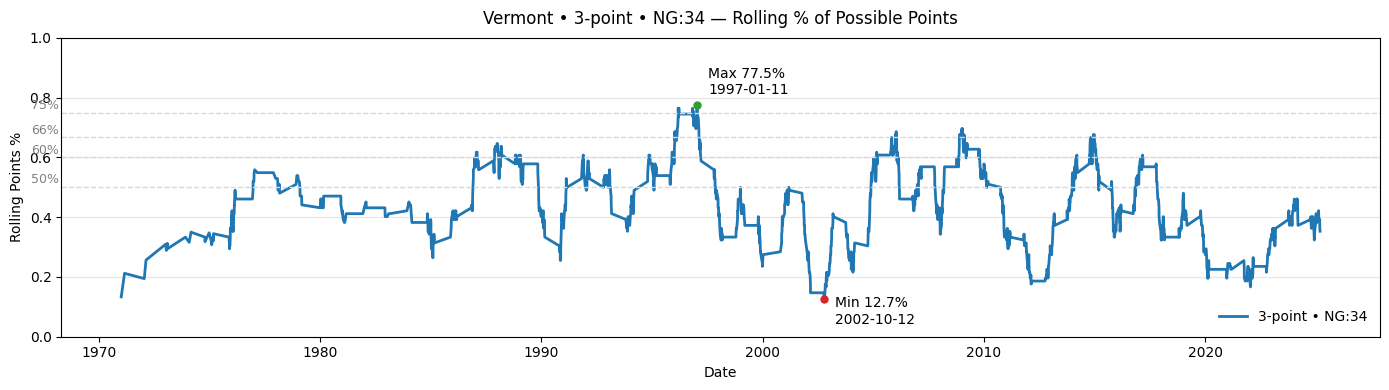

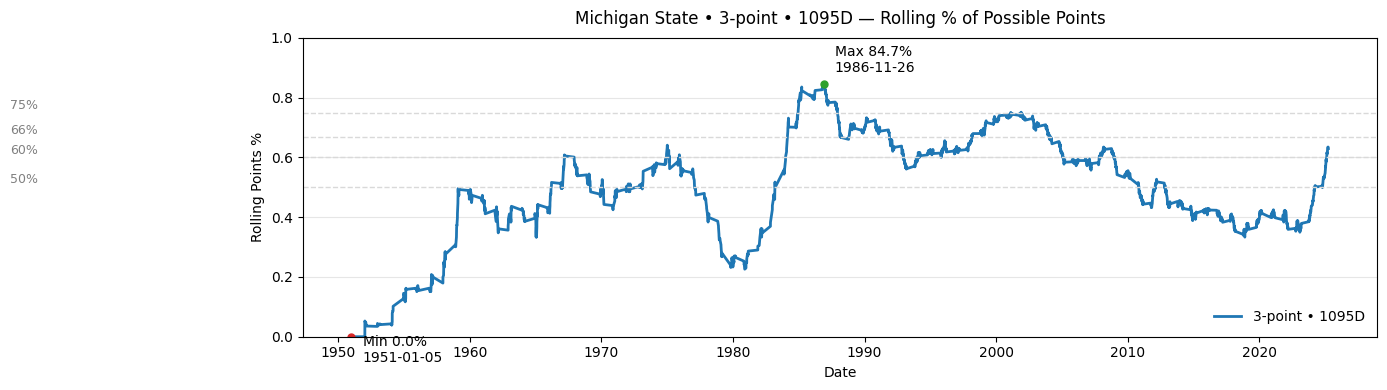

In [160]:
# If you saved multiple outputs, pick one; or concat several then filter below
from matplotlib import pyplot as plt

plot_team_points_pct(ts_ng, "Vermont", system="3-point", window="NG:34")
plt.show()

plot_team_points_pct(ts_time, "Michigan State", system="3-point", window="1095D")
plt.show()


C:\Users\jbanc\AppData\Local\Temp\ipykernel_17280\2822332666.py:267: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolled = g.groupby("team_id", group_keys=False).apply(_roll)
C:\Users\jbanc\AppData\Local\Temp\ipykernel_17280\2822332666.py:267: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolled = g.groupby("team_id", group_keys=False).apply(_roll)


(<Figure size 1400x400 with 1 Axes>,
 <Axes: title={'center': 'Michigan State — Rolling % of Possible Points'}, xlabel='Date', ylabel='Rolling Points %'>)

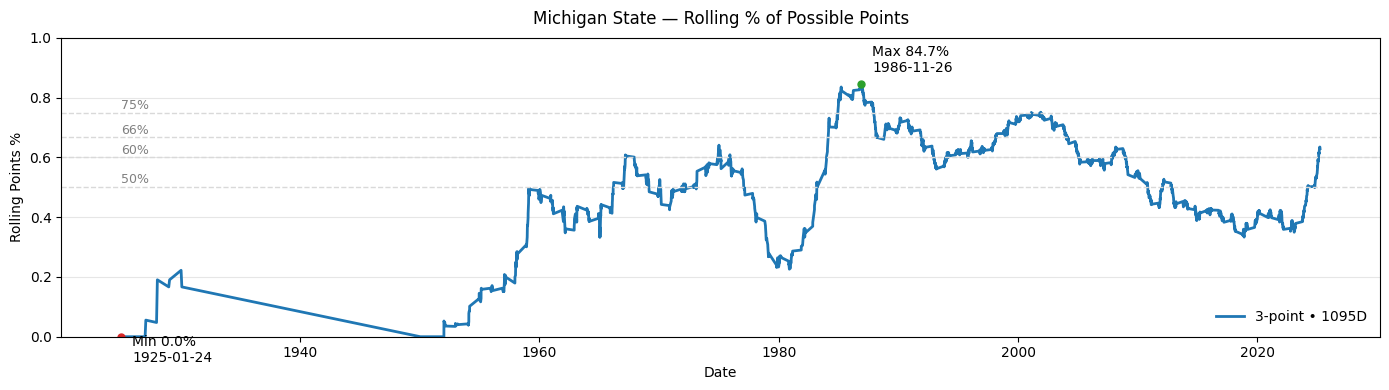

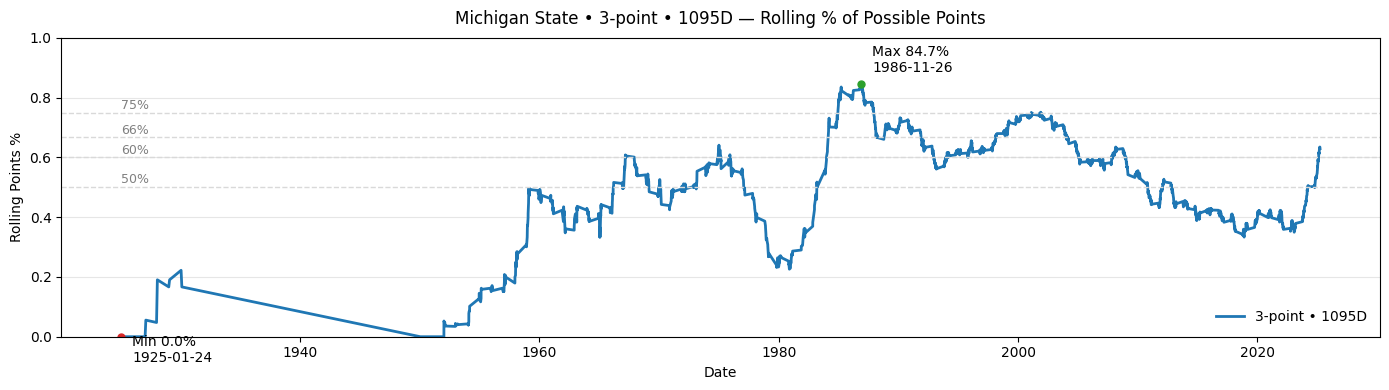

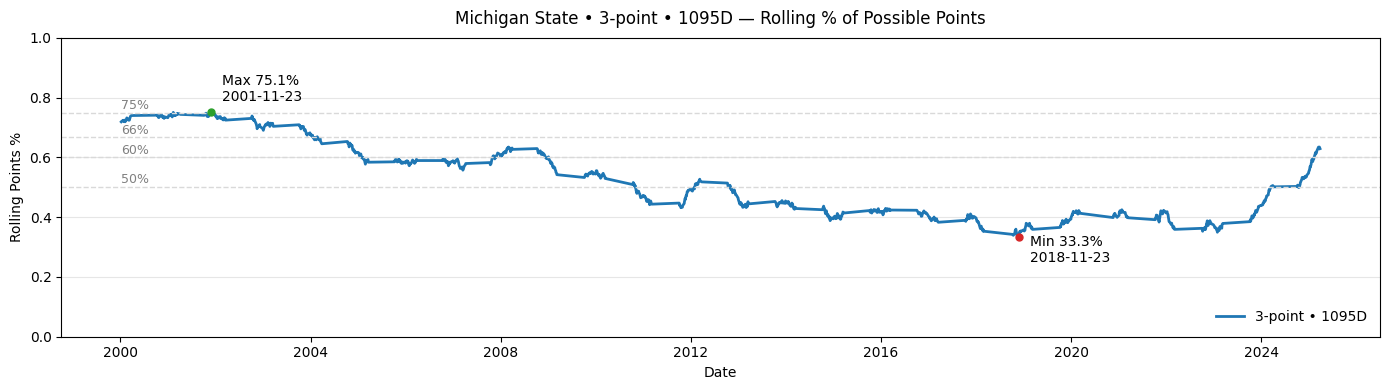

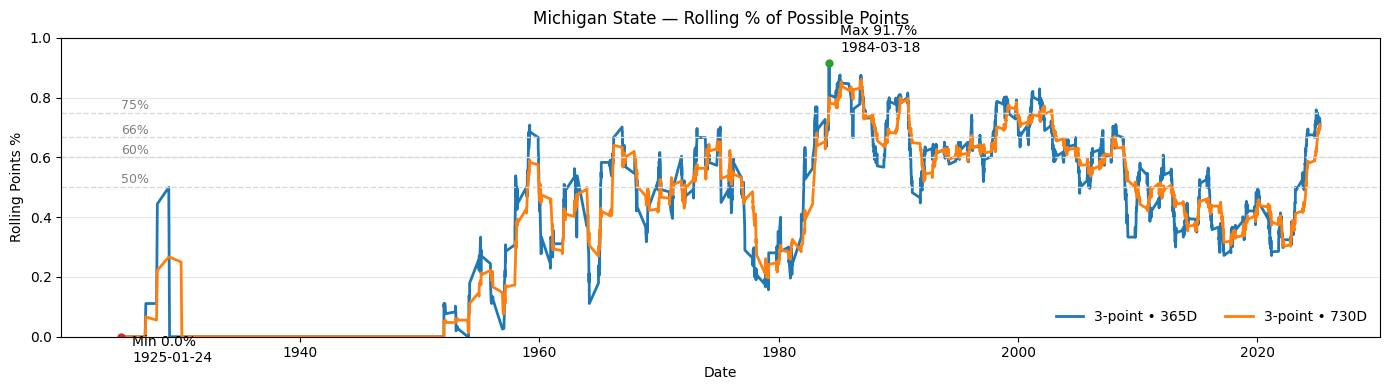

In [161]:
# Load the timeseries produced by build_points_timeseries(...)
ts = pd.read_csv("../data/tables/points_timeseries_3yr_modern.csv", parse_dates=["Date"])

# 1) Single team, single series (already filtered at write-time)
plot_team_points_pct(ts, "Michigan State")

# 2) If your table contains multiple systems/windows, select one:
plot_team_points_pct(ts, "Michigan State", system="3-point", window="1095D")

# 3) Trim to modern era
plot_team_points_pct(ts, "Michigan State", system="3-point", window="1095D",
                     date_range=(pd.Timestamp("2000-01-01"), None))

# 4) Compare multiple series in one plot (if ts contains them)
ts_multi = pd.concat([
    build_points_timeseries(RAW, system=POINTS_3PT, window="730D"),
    build_points_timeseries(RAW, system=POINTS_3PT, window="365D"),
], ignore_index=True)
plot_team_points_pct(ts_multi, "Michigan State")  # will auto-legend both windows


# Vizualizations - Games and Goals +/-

## Matplot Lib Single Team Plot
- over/under .500, goal differential or both

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from typing import Optional, Tuple, List, Union, Dict

# ---------- small helpers ----------

def _select_team(timeline: pd.DataFrame, team: Union[str, int]) -> pd.DataFrame:
    """Return a sorted copy of the team rows by team name (casefold) or team_id (int)."""
    if isinstance(team, (int, np.integer)):
        g = timeline.loc[timeline["team_id"] == int(team)].copy()
    else:
        g = timeline.loc[timeline["team"].str.casefold() == str(team).casefold()].copy()
    if g.empty:
        raise ValueError(f"No rows for team selector: {team!r}")
    if "Date" not in g.columns:
        raise ValueError("timeline must include a 'Date' column parsed as datetime.")
    g = g.sort_values("Date").reset_index(drop=True)
    return g

def _maybe_compute_cum_gd(g: pd.DataFrame) -> pd.DataFrame:
    """If cum_gd missing but gf/ga present, compute it. Otherwise raise nicely."""
    if "cum_gd" not in g.columns:
        if {"cum_gf", "cum_ga"}.issubset(g.columns):
            g = g.copy()
            g["cum_gd"] = (g["cum_gf"] - g["cum_ga"]).astype(float)
        elif {"gf", "ga"}.issubset(g.columns):
            g = g.copy()
            g["cum_gd"] = g.groupby("team_id")["gf"].cumsum() - g.groupby("team_id")["ga"].cumsum()
            g["cum_gd"] = g["cum_gd"].astype(float)
        else:
            raise ValueError("timeline needs 'cum_gd' or ('gf','ga') or ('cum_gf','cum_ga').")
    return g

def _add_logo(ax: plt.Axes, logo_path: Optional[Union[str, Path]], zoom: float = 0.15,
              loc: Tuple[float, float] = (0.92, 0.18)) -> None:
    """Add a semi-transparent logo inside the axes at axes-fraction coords."""
    if not logo_path:
        return
    p = Path(logo_path)
    if not p.exists():
        return
    try:
        arr = plt.imread(p)
        imagebox = OffsetImage(arr, zoom=zoom)
        ab = AnnotationBbox(imagebox, loc, xycoords="axes fraction", frameon=False)
        ab.set_alpha(0.25)
        ax.add_artist(ab)
    except Exception:
        # Silently skip if Pillow/format hiccup
        pass




# ---------- main plotter ----------
# ----------VERSION 2---------------
def plot_team_timeline(
    timeline: pd.DataFrame,
    team: Union[str, int],
    mode: str = "both",
    time_scale: str = "date",           # "date" | "games" | "compressed-date"  <-- add
    style: str = "slope",
    figsize: Tuple[int, int] = (16, 6),
    colors: Optional[Dict[str, str]] = None,
    era_marks: Optional[List[pd.Timestamp]] = None,
    era_bands: Optional[List[Tuple[pd.Timestamp, pd.Timestamp, str]]] = None,
    annotate: bool = True,
    show_legend: bool = False,
    logo_path: Optional[Union[str, Path]] = None,
):


    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox

    # ---- defaults + team slice ----
    C = dict(
        games_line="#0B6E4F", games_fill_pos="#BFE3D2", games_fill_neg="#E5C7C2",
        gd_line="#8B6B00",    gd_fill_pos="#F0E2B6",    gd_fill_neg="#E9D2C0",
        grid="0.85",
    )
    if colors: C.update(colors)

    g = _select_team(timeline, team)          # your helper from before
    g = _maybe_compute_cum_gd(g)              # ensures cum_gd exists


    # # time_scale: "date" | "games" | "compressed-date"
    # ts = time_scale.strip().lower()
    # if ts == "date":
    #     x = g["Date"].values
    # elif ts == "games":
    #     x = np.arange(len(g))
    # elif ts == "compressed-date":
    #     x = make_compressed_x(g["Date"], max_gap_days=21, keep_gap_days=3)
    # else:
    #     raise ValueError("time_scale must be 'date', 'games', or 'compressed-date'")

    # ----------ORIG-VERSION 1----------
    # ---- x-axis: calendar dates vs game index vs compressed-date ----
    ts = time_scale.strip().lower()
    if ts == "date":
        x = g["Date"].values
        year_ticks = None  # DateLocator handles it
    elif ts == "games":
        x = np.arange(len(g))
        first_per_year = g.groupby(g["Date"].dt.year, as_index=False).head(1)
        year_ticks = (first_per_year.index.to_numpy(), first_per_year["Date"].dt.year.astype(str).to_list())
    elif ts == "compressed-date":
        x = make_compressed_x(g["Date"], max_gap_days=21, keep_gap_days=3)
        # label ticks at the first game of each year (same as games mode)
        first_per_year = g.groupby(g["Date"].dt.year, as_index=False).head(1)
        year_ticks = (first_per_year.index.to_numpy(), first_per_year["Date"].dt.year.astype(str).to_list())
    else:
        raise ValueError("time_scale must be 'date' or 'games' or 'compressed-date'")


    y_games = g["games_above_500"].astype(float).values
    y_gd    = g["cum_gd"].astype(float).values

    fig, axL = plt.subplots(figsize=figsize)
    axR = None

    # grid & baseline
    axL.grid(True, axis="y", color=C["grid"], lw=0.8, alpha=0.8)
    axL.axhline(0, color="0.25", lw=1)

    if ts in ("games", "compressed-date") and year_ticks is not None:
        pos, lab = year_ticks
        axL.set_xticks(pos)
        axL.set_xticklabels(lab, rotation=45, ha="right")


    # ---- plotting primitives (slope vs step) ----
    def _draw(ax, y, line_color, fill_pos, fill_neg, use_step: bool, label: str):
        if use_step:
            ax.step(x, y, where="post", lw=2.0, color=line_color, label=label)
            ax.fill_between(x, 0.0, y, where=y>0, step="post", alpha=0.28, color=fill_pos)
            ax.fill_between(x, 0.0, y, where=y<0, step="post", alpha=0.22, color=fill_neg)
        else:
            ax.plot(x, y, lw=2.0, color=line_color, label=label)
            # interpolate=True makes the fills meet the zero line cleanly
            ax.fill_between(x, 0.0, y, where=y>0, alpha=0.28, color=fill_pos, interpolate=True)
            ax.fill_between(x, 0.0, y, where=y<0, alpha=0.22, color=fill_neg, interpolate=True)

    use_step = (style == "step")

    if mode in ("games", "both"):
        _draw(axL, y_games, C["games_line"], C["games_fill_pos"], C["games_fill_neg"], use_step, "Games ± .500")
        axL.set_ylabel("Games Above/Below .500")

    if mode == "gd":
        _draw(axL, y_gd, C["gd_line"], C["gd_fill_pos"], C["gd_fill_neg"], use_step, "Cumulative GD")
        axL.set_ylabel("Cumulative Goal Differential")

    if mode == "both":
        axR = axL.twinx()
        _draw(axR, y_gd, C["gd_line"], C["gd_fill_pos"], C["gd_fill_neg"], use_step, "Cumulative GD")
        axR.set_ylabel("Cumulative Goal Differential")

    # ---- era bands (ranges) ----
    # helper: convert a real date to x for any time_scale
    # def _x_from_date(dt):
    #     if time_scale == "date":
    #         return pd.Timestamp(dt)
    #     elif time_scale == "games":
    #         idx = g.index[g["Date"] >= pd.Timestamp(dt)]
    #         return int(idx[0]) if len(idx) else None
    #     elif time_scale == "compressed-date":
    #         # you already built x = make_compressed_x(g["Date"], ...)
    #         # so map date -> nearest index, then use that x value
    #         idx = g.index[g["Date"] >= pd.Timestamp(dt)]
    #         return x[int(idx[0])] if len(idx) else None
    def _x_from_date(dt):
        dt = pd.Timestamp(dt)
        if ts == "date":
            return dt
        # find first index at/after dt
        idx = g.index[g["Date"] >= dt]
        if not len(idx):
            return None
        i = int(idx[0])
        return x[i]  # works for both 'games' (x=i) and 'compressed-date' (x=compressed[i])


    if era_bands:
        for (s, e, label) in era_bands:
            xs, xe = _x_from_date(s), _x_from_date(e)
            if xs is None or xe is None: 
                continue
            axL.axvspan(xs, xe, color="0.90", alpha=0.6, lw=0, zorder=0)
            # label in-band near the top-left of the span
            try:
                axL.text(xs, axL.get_ylim()[1]*0.92, str(label), fontsize=9, alpha=0.7)
            except Exception:
                pass

    # ---- era marks (single date lines) ----
    if era_marks:
        for dt in era_marks:
            xv = _x_from_date(dt)
            if xv is not None:
                axL.axvline(xv, ls="--", lw=0.8, color=colors.get("grid","0.85") if colors else "0.85", zorder=0)


    # ---- annotations ----
    if annotate:
        # games ± .500
        if mode in ("games", "both"):
            iMax, iMin = int(np.nanargmax(y_games)), int(np.nanargmin(y_games))
            axL.plot(x[iMax], y_games[iMax], "o", ms=5, color=C["games_line"])
            axL.annotate(f"Highest: {int(y_games[iMax])}\n{pd.to_datetime(g['Date'].iloc[iMax]).date()}",
                         (x[iMax], y_games[iMax]), xytext=(10, 10), textcoords="offset points")
            axL.plot(x[iMin], y_games[iMin], "o", ms=5, color=C["games_line"])
            axL.annotate(f"Lowest: {int(y_games[iMin])}\n{pd.to_datetime(g['Date'].iloc[iMin]).date()}",
                         (x[iMin], y_games[iMin]), xytext=(10, -20), textcoords="offset points")

        # GD
        if mode in ("gd", "both"):
            jMax, jMin = int(np.nanargmax(y_gd)), int(np.nanargmin(y_gd))
            tgt = axR if (mode == "both") else axL
            tgt.plot(x[jMax], y_gd[jMax], "o", ms=5, color=C["gd_line"])
            tgt.annotate(f"Highest GD: {int(y_gd[jMax])}\n{pd.to_datetime(g['Date'].iloc[jMax]).date()}",
                         (x[jMax], y_gd[jMax]), xytext=(10, 10), textcoords="offset points")
            tgt.plot(x[jMin], y_gd[jMin], "o", ms=5, color=C["gd_line"])
            tgt.annotate(f"Lowest GD: {int(y_gd[jMin])}\n{pd.to_datetime(g['Date'].iloc[jMin]).date()}",
                         (x[jMin], y_gd[jMin]), xytext=(10, -22), textcoords="offset points")

    # ---- ticks: if game-index axis, label first game of each year ----
    if time_scale == "games" and year_ticks is not None:
        pos, lab = year_ticks
        axL.set_xticks(pos)
        axL.set_xticklabels(lab, rotation=45, ha="right")

    team_name = g["team"].iloc[0]
    axL.set_xlabel("Date" if time_scale=="date" else "Games (compressed off-season)")
    axL.set_title(f"{team_name}: {'Games ±.500' if mode=='games' else 'Cumulative GD' if mode=='gd' else 'Games ±.500  &  Cumulative GD'} — {time_scale}/{style}", pad=10)
    axL.margins(x=0.01)

    # optional logo (same helper as before)
    _add_logo(axL, logo_path, zoom=0.18, loc=(0.93, 0.2))

    if show_legend:
        axL.legend(loc="upper left", frameon=False)

    plt.tight_layout()
    return fig, (axL, axR)








In [163]:
# Load your per-game timeline (created by the pipeline)
tl = pd.read_csv("../data/tables/team_timeseries.csv", parse_dates=["Date"])


(<Figure size 1600x600 with 1 Axes>,
 (<Axes: title={'center': 'Michigan State: Cumulative GD — date/slope'}, xlabel='Date', ylabel='Cumulative Goal Differential'>,
  None))

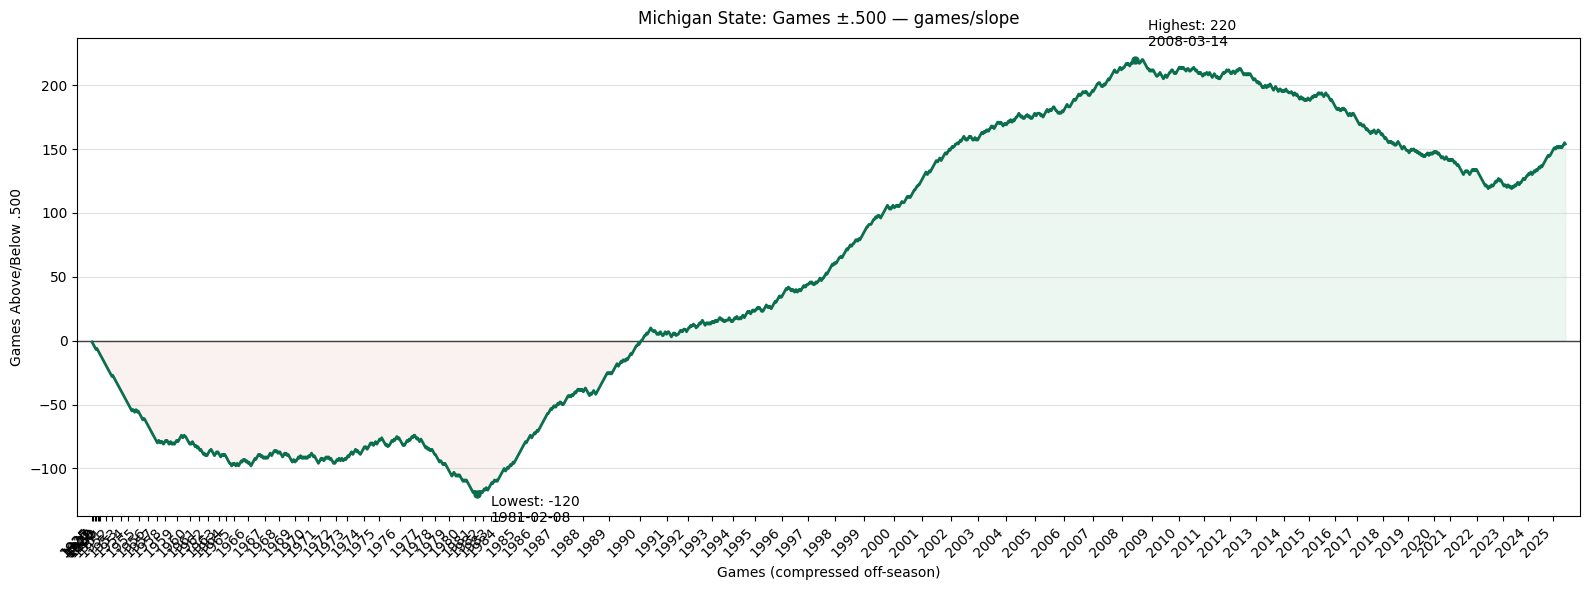

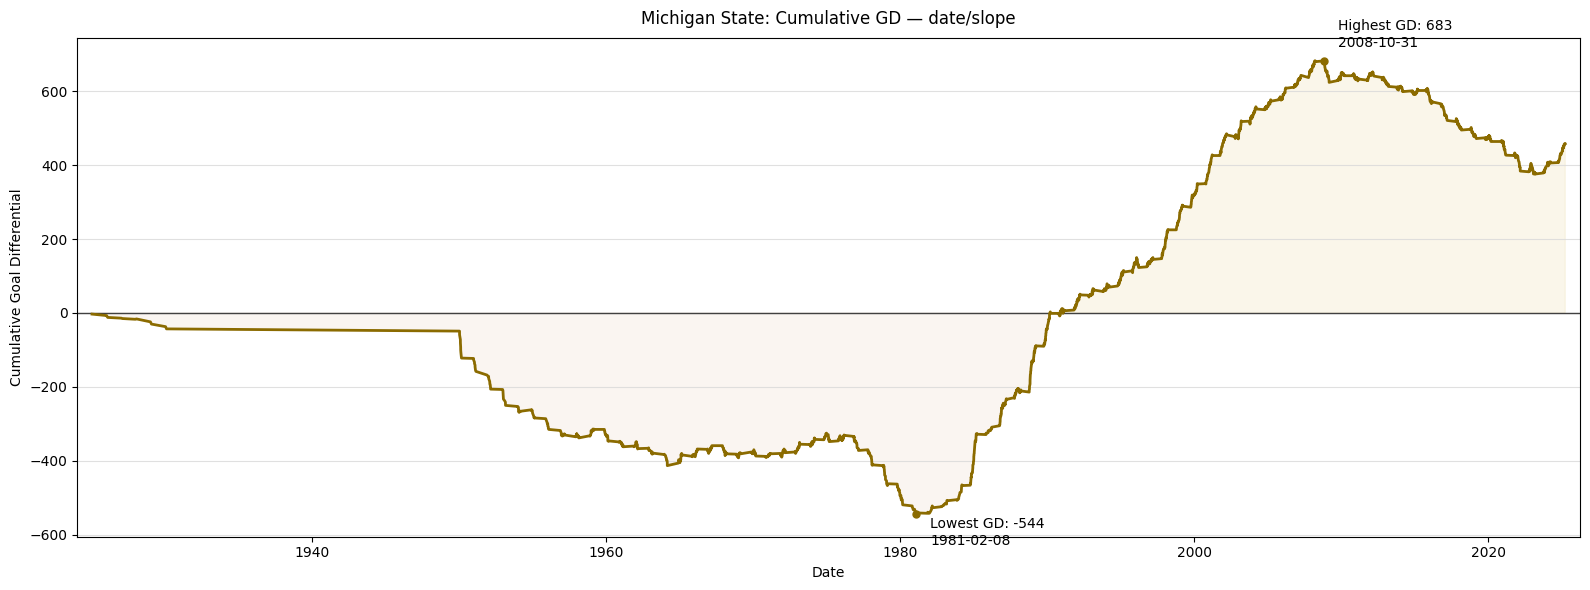

In [164]:
# Games ± .500 only
plot_team_timeline(
    tl, "Michigan State",
    mode="games",
    time_scale="games",
    style="slope"
)

# Cumulative Goal Differential only
plot_team_timeline(
    tl, "Michigan State",
    mode="gd",
    time_scale="date",
    style="slope"
)



(<Figure size 1600x600 with 1 Axes>,
 (<Axes: title={'center': 'Wisconsin: Games ±.500 — games/slope'}, xlabel='Games (compressed off-season)', ylabel='Games Above/Below .500'>,
  None))

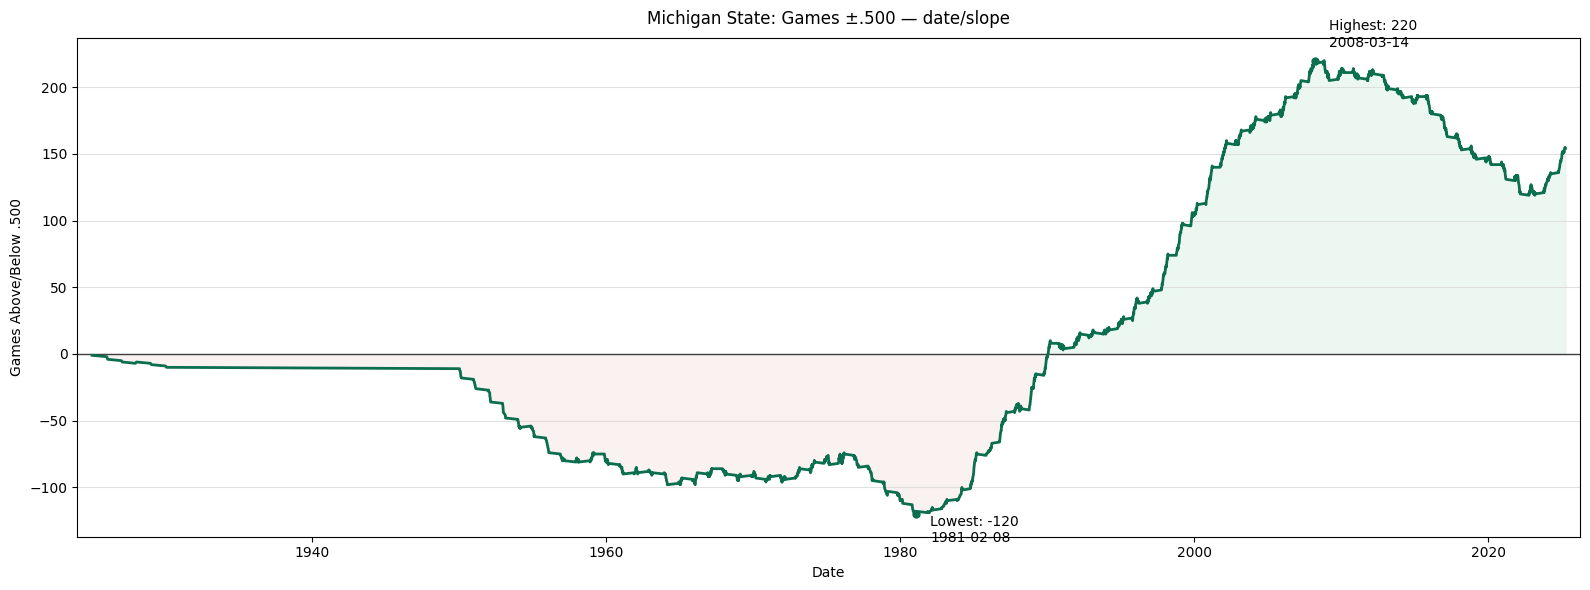

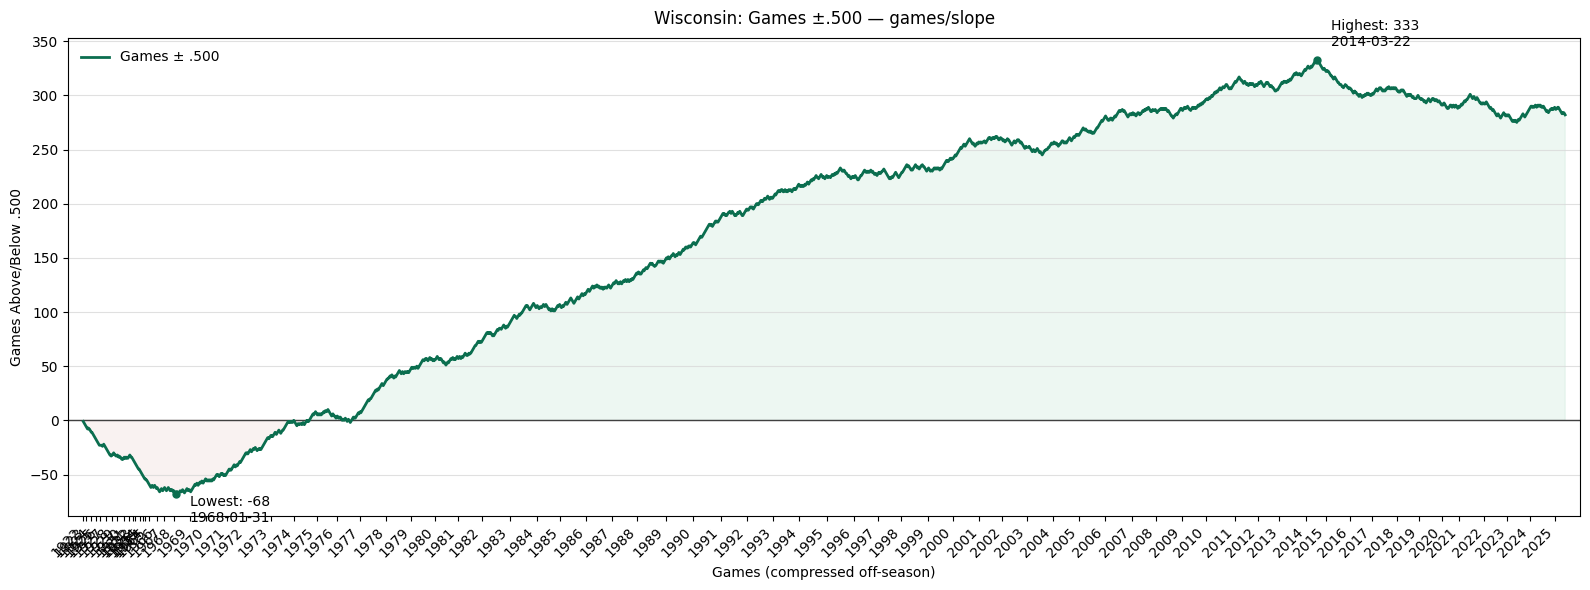

In [165]:
## Call Version 2 of Plotting Function
plot_team_timeline(tl, "Michigan State", mode="games",
                   time_scale="date", style="slope")

plot_team_timeline(tl, "Wisconsin", mode="games",
                   time_scale="games", style="slope", show_legend=True)


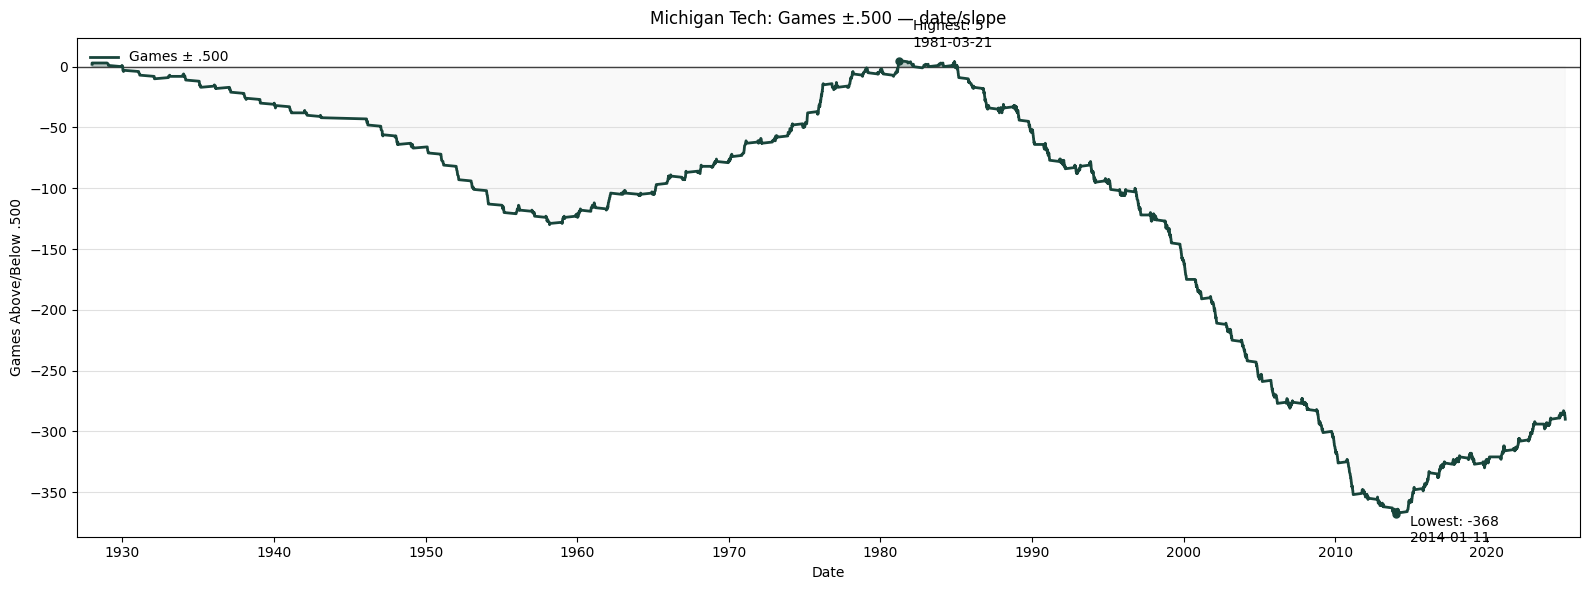

In [167]:
# 1) Pick a team
team_key = "Michigan Tech"   # or a numeric team_id

# 2) Pull brand pack (colors + logo)
brand = get_team_brand(school_info_df, team_key, white_to_gray=True)
plot_colors = brand_to_plot_colors(brand)

# 3) Build coaching eras
eras = coach_eras_for_team(team_history_df, team_key)
era_bands = eras_to_bands(eras)

# 4) Plot (uses your existing plot_team_timeline function)
#    Choose your time_scale and mode as you like.
_ = plot_team_timeline(
    timeline=tl,                     # your per-game timeline with Date parsed
    team=team_key,
    mode="games",                     # "games" | "gd" | "both"
    time_scale="date",    # or "date"/"games"
    style="slope",
    colors=plot_colors,
    era_bands=era_bands,             # shaded bands with coach names
    logo_path=brand.logo_path,       # optional watermark
    show_legend=True,
)
